In [ ]:
!pip install tf-nightly

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.__version__

'2.5.0-dev20201123'

In [2]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159  100   159    0     0    243      0 --:--:-- --:--:-- --:--:--   243
100 8863k  100 8863k    0     0  7416k      0  0:00:01  0:00:01 --:--:-- 25.8M


In [2]:

# Path to the data directory
data_dir = Path("./captcha_images_v2/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'w', '6', 'm', 'b', 'e', 'y', 'x', '2', '4', '8', '7', 'n', 'f', 'g', '3', 'c', 'p', 'd', '5'}


In [7]:
import json

with open('char_to_num.json', 'r') as fp:
    char_to_num_dict = json.load(fp)

with open('num_to_char.json', 'r') as fp:
    num_to_char_dict = json.load(fp)


def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = "".join([num_to_char_dict[str(val)] for val in res.numpy()])
        output_text.append(res)
    return output_text

['226md']


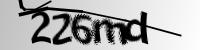

In [8]:
# Inference with TFLite
import cv2
from google.colab.patches import cv2_imshow

image_path = '/content/captcha_images_v2/226md.png'
# 1. Read image
img = tf.io.read_file(image_path)
# 2. Decode and convert to grayscale
img = tf.io.decode_png(img, channels=1)
# 3. Convert to float32 in [0, 1] range
img = tf.image.convert_image_dtype(img, tf.float32)
# 4. Resize to the desired size
img = tf.image.resize(img, [img_height, img_width])
# 5. Transpose the image because we want the time
# dimension to correspond to the width of the image.
img = tf.transpose(img, perm=[1, 0, 2])
interpreter = tf.lite.Interpreter(model_path="ocr_dr.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.expand_dims(img, 0)
# input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
preds = interpreter.get_tensor(output_details[0]['index'])

pred_texts = decode_batch_predictions(preds)

print(pred_texts)

show_image = cv2.imread(image_path)
cv2_imshow(show_image)